**TCC BI 2019_4**

# **Previsão de cancelamentos em hotéis usando modelos de classificação.**<br>

Exploração dos dados e utilização de modelos de Machine Learning Supervisionados de Classificação, o evento é o cancelamento ou não da reserva.<br>

Marine Patricia Chevallier

## Uma breve introdução sobre a base de dados

Nesse desafio, suponho que a variável **is_canceled** = 1 quer dizer que a reserva foi cancelada e que **is_canceled** = 0 que não foi cancelada.



# Importando as bibliotecas necessárias

In [2]:
# !pip install missingno
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno


from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectPercentile
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import plotly.express as px


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Importando a base de dados

In [3]:
df = pd.read_csv('/content/hotel_bookings.csv')

# Pré-processamento dos Dados

In [4]:
df.shape

(119390, 32)

In [5]:
df.duplicated().any()

True

In [6]:
# removendo as reservas duplicadas
df.drop_duplicates(inplace=False)

In [ ]:
# porcentagem de linhas vazias por coluna
null = 100 * (df.isna().sum()/ df.shape[0])
null

Variáveis com valores faltantes:

1. num_children (pouco)
2. country
3. id_travel_agency_booking
4. id_person_booking

Vemos que a variável **id_person_booking** tem mais de 94% de valores nulos, o que implica na exclusão dessa coluna.

In [ ]:
df.drop(columns='id_person_booking', axis=1, inplace=True)

In [9]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


É impossivel ter uma reserva em que a quantidade de adultos seja nula ao mesmo tempo que a de crianças e bebês. Iremos remover esses casos da nossa base de dados.

In [11]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [12]:
filter = (df.adults ==0 ) & (df.children ==0 ) & (df.babies ==0 )
filter.value_counts()

False    119210
True        180
dtype: int64

In [13]:
df = df[~filter]

Também é impossivel ter reservas em que não foram feitas nem durante a semana nem durante o final de semana. Também vamos remover esses casos

In [14]:
another_filter =  ((df.stays_in_weekend_nights ==0 ) & (df.stays_in_week_nights ==0 ))
another_filter.value_counts()

False    118565
True        645
dtype: int64

In [15]:
df = df[~another_filter]

# Análise Exploratória dos Dados

In [16]:
for coluna in df.columns:
    grafico = px.histogram(df, x=coluna, color="is_canceled")
    grafico.show()

Output hidden; open in https://colab.research.google.com to view.

In [17]:
df.hotel.value_counts()

City Hotel      78899
Resort Hotel    39666
Name: hotel, dtype: int64

Cancelamentos em Resort Hotel =  0.28008874098724346
Cancelamentos em City Hotel =  0.4190927641668462


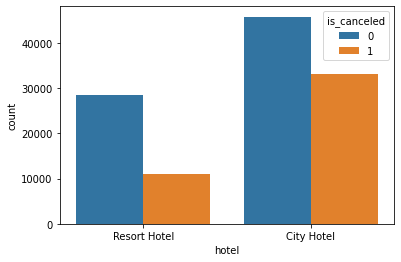

In [18]:
sns.countplot(data=df, x='hotel', hue='is_canceled')
resort_canceled = df[(df['hotel']=='Resort Hotel') & (df['is_canceled']==1)]
city_canceled = df[(df['hotel']=='City Hotel') & (df['is_canceled']==1)]
print('Cancelamentos em Resort Hotel = ', (len(resort_canceled))/(len(df[df['hotel']=='Resort Hotel'])))
print('Cancelamentos em City Hotel = ', (len(city_canceled))/(len(df[df['hotel']=='City Hotel'])))

Há mais cancelamentos em City Hotel do que em Resort Hotel.



Há maiores cancelamentos quando a reserva foi feita entre 60 e 70 dias antes da data de check-in.
Quanto maior a quantidade de dias entre a reserva e a data de chegada, menor o cancelamento. Isso invalida a segunda suposição.

In [19]:
# conferindo a porcentagem de reservas que tenha crianças ou bebês
((len(df.loc[(df['children']!=0) | (df['babies']!=0)]))/(len(df))) * 100

# porcentagem baixa, irrelevante na análise.

7.8412685025091715

A porcentagem de reservas que tenham crianças ou bebês é baixa, o que torna essa hipótese 3 irrelevante na análise.

Cancelamentos dos novos hóspedes =  0.38
Cancelamentos dos antigos hóspedes =  0.16


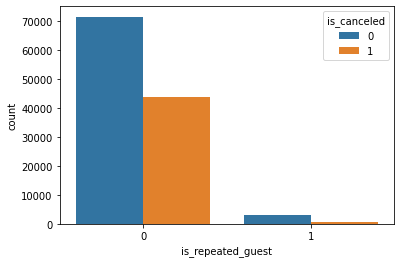

In [22]:
sns.countplot(data=df, x='is_repeated_guest', hue='is_canceled')
new_guest = df[(df['is_repeated_guest']==0) & (df['is_canceled']==1)]
old_guest = df[(df['is_repeated_guest']==1) & (df['is_canceled']==1)]
print('Cancelamentos dos novos hóspedes = ', round((len(new_guest))/(len(df[df['is_repeated_guest']==0])),2))
print('Cancelamentos dos antigos hóspedes = ', round((len(old_guest))/(len(df[df['is_repeated_guest']==1])),2))

Há maiores cancelamentos entre os novos hóspedes.

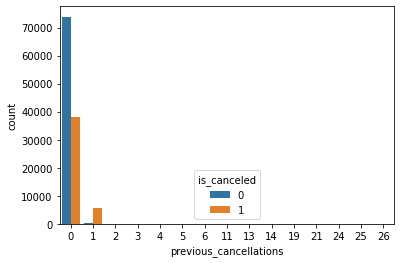

In [23]:
sns.countplot(data=df, x='previous_cancellations', hue='is_canceled')

Os clientes que já cancelaram uma vez, tem maior probabilidade de cancelar a reserva atual. O que confirma a correlação positiva entre o num_previous_cancellations com a variavel cancellation.

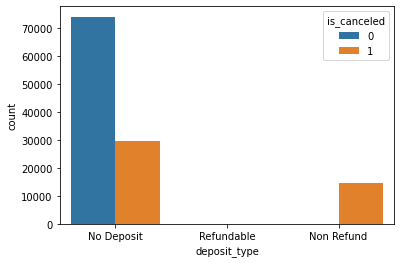

In [25]:
# fig, ax = plt.subplots(figsize=(14,7))
sns.countplot(x="deposit_type", hue="is_canceled",data=df);

As reservas não reembolsáveis também são canceladas.

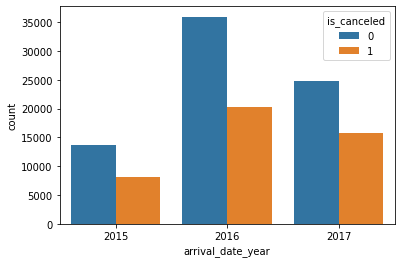

In [26]:
sns.countplot(data=df, x='arrival_date_year', hue='is_canceled')

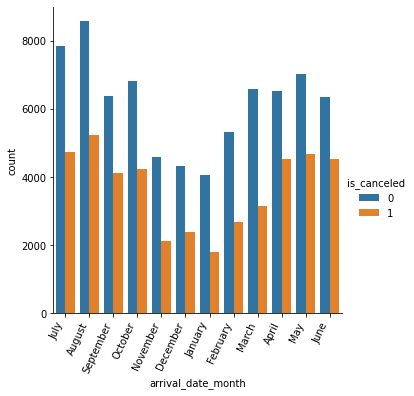

In [27]:
chart = sns.catplot(data=df, x='arrival_date_month', hue='is_canceled', kind='count')
chart.set_xticklabels(rotation=65, horizontalalignment='right')

Máximo de reservas ocorreu em 2016 nos meses de julho e agosto, verão europeu.

Para avaliar se em Resort Hotel o periodo de reserva costuma ser maior do que em City Hotel, foi criada uma nova variável 'total_nights' que é a soma de 'num_weekend_nights' com 'num_workweek_nights' e também filtramos apenas as reservas que não foram canceladas.

In [28]:
df['total_nights'] = df.stays_in_weekend_nights + df.stays_in_week_nights

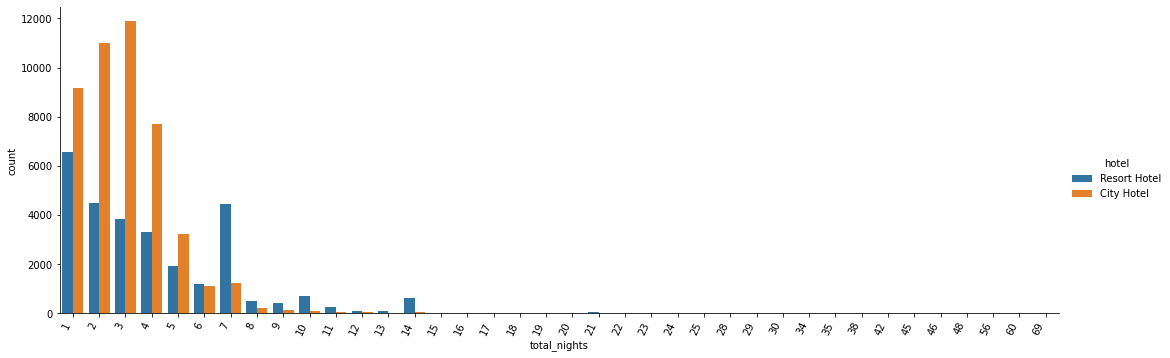

In [29]:
chart = sns.catplot(data=df[df['is_canceled']==0], x='total_nights', hue='hotel', kind='count', aspect=15/5)
chart.set_xticklabels(rotation=65, horizontalalignment='right')

Vemos que a partir de 7 noites, as reservas predominantes são para Resort Hotel.

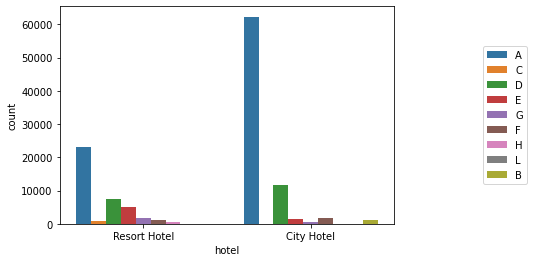

In [30]:
g = sns.countplot(data=df, x='hotel', hue='reserved_room_type')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

* Quartos mais reservados em Fancy Hotel: A, D e E
* Quartos mais reservados em Hotel: A,D e F (bem menos)

In [31]:
guest_country = df[df.is_canceled==0]['country'].value_counts().reset_index()
guest_country.columns = ['Country', 'No of guests']
guest_country.head()

,Country,No of guests
0,PRT,20449
1,GBR,9644
2,FRA,8457
3,ESP,6368
4,DEU,6067


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning:

Using the countplot function without specifying `order` is likely to produce an incorrect plot.



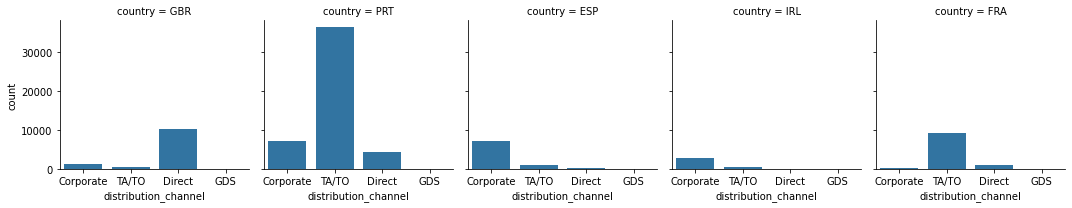

In [32]:
temp = df.loc[(df['country']=='PRT') | (df['country']=='GBR') | (df['country']=='ESP') | (df['country']=='FRA') | (df['country']=='IRL')]
grid = sns.FacetGrid(temp, col='country')
grid.map(sns.countplot, 'distribution_channel')

Ao saber quais são os canais de distribuição mais utilizados nos 5 países dos hóspedes que mais fazem reservas, pode-se investir em meios de publicidades mais eficazes.

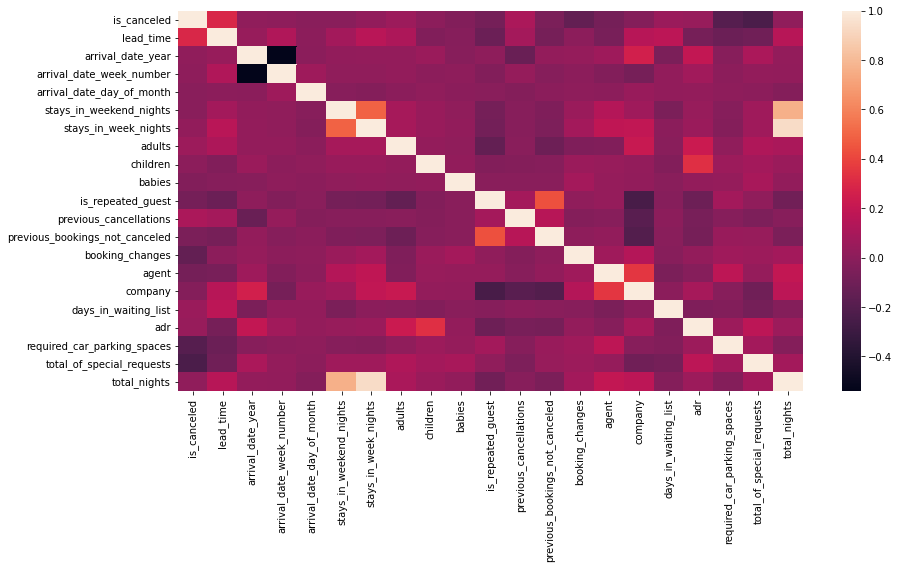

In [33]:
# correlação das variáveis
fig, ax = plt.subplots(figsize=(14,7))
sns.heatmap(df.corr())

In [34]:
corr= df.corr(method='pearson')['is_canceled'][:]
corr

is_canceled                       1.000000
lead_time                         0.291515
arrival_date_year                 0.015438
arrival_date_week_number          0.009019
arrival_date_day_of_month        -0.006108
stays_in_weekend_nights          -0.004859
stays_in_week_nights              0.020703
adults                            0.057575
children                          0.004690
babies                           -0.032672
is_repeated_guest                -0.077791
previous_cancellations            0.109974
previous_bookings_not_canceled   -0.057541
booking_changes                  -0.145198
agent                            -0.082325
company                          -0.024795
days_in_waiting_list              0.053941
adr                               0.039368
required_car_parking_spaces      -0.196804
total_of_special_requests        -0.236165
total_nights                      0.013554
Name: is_canceled, dtype: float64

In [35]:
df['is_canceled'].value_counts(normalize=True)

0    0.627411
1    0.372589
Name: is_canceled, dtype: float64

# Features engineering

In [36]:
month_map = {'January':'01', 'February':'02', 'March':'03', 'April':'04', 'May':'05', 'June':'06', 'July':'07', 'August':'08', 'September':'09', 'October':'10', 'November':'11', 'December':'12'}
df['arrival_date_month'] = df.arrival_date_month.map(month_map).astype(int)

In [37]:
# criando a data de chegada
df['arrival_date'] = df['arrival_date_year'].astype(str)+'-'+df['arrival_date_month'].astype(str)\
                        +'-'+df['arrival_date_day_of_month'].astype(str)
# passando pra formato de data
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

In [38]:
# # preenchendo as linhas vazias de crianças por 0
df['children'] = df['children'].fillna(0)
# criando uma nova coluna com a quantidade de filhos
df['offspring'] = (df['children'] + df['babies']).astype(int)

In [39]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_nights',
       'arrival_date', 'offspring'],
      dtype='object')

In [40]:
# criando uma nova coluna com o total de reservas
df['total_bookings'] = df['previous_cancellations'] + df['previous_bookings_not_canceled']

In [41]:
# # preenchendo as linhas vazias de país com o mais frequente
df['country'].fillna(df['country'].mode()[0], inplace=True)
# # preenchendo as linhas vazias do id da agencia de viagem com o mais frequente
df['agent'].fillna(df['agent'].mode()[0], inplace=True)

In [46]:
df_model = df[['hotel', 'deposit_type','country', 'market_segment', 'distribution_channel', 'customer_type', 'is_canceled']]

In [47]:
df_model.head()

,hotel,deposit_type,country,market_segment,distribution_channel,customer_type,is_canceled
2,Resort Hotel,No Deposit,GBR,Direct,Direct,Transient,0
3,Resort Hotel,No Deposit,GBR,Corporate,Corporate,Transient,0
4,Resort Hotel,No Deposit,GBR,Online TA,TA/TO,Transient,0
5,Resort Hotel,No Deposit,GBR,Online TA,TA/TO,Transient,0
6,Resort Hotel,No Deposit,PRT,Direct,Direct,Transient,0


In [48]:
# transformando as variáveis categóricas nominais em categóricas numéricas
lb = LabelEncoder()
var = ['hotel', 'deposit_type', 'country']
for item in var:
    df_model[item] = lb.fit_transform(df_model[item])
# transformando as variáveis categóricas em dummies para o modelo não considerar as categorias como números
df_model = pd.get_dummies(df_model, columns=['hotel', 'deposit_type','country', 'market_segment', 'distribution_channel', 'customer_type'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Modelos de Classificação

Separando os dados em treino e teste.

Os dados na base de treino, são usados para construir e treinar o modelo, enquanto os dados na base de teste, testam a performance do modelo fora da amostra (com dados novos). Sempre vai existir uma diferença de performance do modelo nas diferentes bases (treino e teste).

Foi colocado 20% como tamanho de teste.

In [50]:
X = df_model.drop(['is_canceled'], axis=1)
y = df_model['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((94852, 199), (94852,), (23713, 199), (23713,))

### Padronizando e normalizando os dados

Faz-se necessário padronizar e normalizar os dados para que as variáveis tenham a mesma ordem de grandeza.

In [52]:
# Padronizando os dados
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

# Normalizando os dados
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)
X_train_mm = mm_scaler.transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

## Regressão Logística

Esse é um dos algoritmos mais utilizados no aprendizado de máquina supervisionado para resolver problemas de classificação. Ela prevê a variável dependente categórica usando um determinado conjunto de variáveis independentes.

In [54]:
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train_mm, y_train)

y_pred_logreg = logreg.predict(X_test_mm)

acc_logreg = accuracy_score(y_test, y_pred_logreg)
conf = confusion_matrix(y_test, y_pred_logreg)
clf_report = classification_report(y_test, y_pred_logreg)

print(f"Accuracy Score of Logistic Regression is : {acc_logreg}")
print(f"Confusion Matrix : {conf}")
print(f"Classification Report : {clf_report}")

Accuracy Score of Logistic Regression is : 0.7448656854889723
Confusion Matrix : [[13467  1376]
 [ 4674  4196]]
Classification Report :               precision    recall  f1-score   support

           0       0.74      0.91      0.82     14843
           1       0.75      0.47      0.58      8870

    accuracy                           0.74     23713
   macro avg       0.75      0.69      0.70     23713
weighted avg       0.75      0.74      0.73     23713



## K-Nearest Neighbor

In [55]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
conf = confusion_matrix(y_test, y_pred_knn)
clf_report = classification_report(y_test, y_pred_knn)

print(f"Accuracy Score of KNN is : {acc_knn}")
print(f"Confusion Matrix : n{conf}")
print(f"Classification Report : n{clf_report}")

Accuracy Score of KNN is : 0.7330156454265593
Confusion Matrix : n[[12279  2564]
 [ 3767  5103]]
Classification Report : n              precision    recall  f1-score   support

           0       0.77      0.83      0.80     14843
           1       0.67      0.58      0.62      8870

    accuracy                           0.73     23713
   macro avg       0.72      0.70      0.71     23713
weighted avg       0.73      0.73      0.73     23713



## Árvore de Decisão


In [56]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(y_test, y_pred_dtc)
conf = confusion_matrix(y_test, y_pred_dtc)
clf_report = classification_report(y_test, y_pred_dtc)

print(f"Accuracy Score of Decision Tree is : {acc_dtc}")
print(f"Confusion Matrix : n{conf}")
print(f"Classification Report : n{clf_report}")

Accuracy Score of Decision Tree is : 0.7667945852485978
Confusion Matrix : n[[13168  1675]
 [ 3855  5015]]
Classification Report : n              precision    recall  f1-score   support

           0       0.77      0.89      0.83     14843
           1       0.75      0.57      0.64      8870

    accuracy                           0.77     23713
   macro avg       0.76      0.73      0.74     23713
weighted avg       0.76      0.77      0.76     23713



## Random Forest


In [58]:
rd_clf = RandomForestClassifier()
rd_clf.fit(X_train, y_train)

y_pred_rd_clf = rd_clf.predict(X_test)

acc_rd_clf = accuracy_score(y_test, y_pred_rd_clf)
conf = confusion_matrix(y_test, y_pred_rd_clf)
clf_report = classification_report(y_test, y_pred_rd_clf)

print(f"Accuracy Score of Random Forest is : {acc_rd_clf}")
print(f"Confusion Matrix : n{conf}")
print(f"Classification Report : n{clf_report}")

Accuracy Score of Random Forest is : 0.7669210981318264
Confusion Matrix : n[[13153  1690]
 [ 3837  5033]]
Classification Report : n              precision    recall  f1-score   support

           0       0.77      0.89      0.83     14843
           1       0.75      0.57      0.65      8870

    accuracy                           0.77     23713
   macro avg       0.76      0.73      0.74     23713
weighted avg       0.76      0.77      0.76     23713



## SVC - Support Vector Classification


In [59]:
#Linear SVC
svc = LinearSVC().fit(X_train_mm, y_train)
scores = cross_val_score(svc, X_train_mm, y_train, cv=5)
svc_pred = svc.predict(X_test_mm)
print("Average cross validation score: {:.3f}".format(scores.mean()))
print("Test accuracy: {:.3f}".format(svc.score(X_test_mm, y_test)))
print("F1 score: {:.3f}".format(f1_score(y_test, svc_pred)))
print(confusion_matrix(y_test, svc_pred))

Average cross validation score: 0.748
Test accuracy: 0.744
F1 score: 0.577
[[13510  1333]
 [ 4729  4141]]


## SGD Classifier - Stochastic Gradient Descent learning



In [60]:
#SGD Classifier
sgd = SGDClassifier(alpha=0.1).fit(X_train_std, y_train)
scores = cross_val_score(sgd, X_train_std, y_train, cv=5)
sgd_pred = sgd.predict(X_test_std)
print("Average cross validation score: {:.3f}".format(scores.mean()))
print("Test accuracy: {:.3f}".format(sgd.score(X_test_std, y_test)))
print("F1 score: {:.3f}".format(f1_score(y_test, sgd_pred)))
print(confusion_matrix(y_test, sgd_pred))

Average cross validation score: 0.751
Test accuracy: 0.749
F1 score: 0.502
[[14757    86]
 [ 5867  3003]]


## Ridge Classifier



In [61]:
#Ridge Classifier
rc = RidgeClassifier(alpha=1, normalize=True)
rc.fit(X_train, y_train)
scores = cross_val_score(rc, X_train, y_train, cv=5)
rc_pred = rc.predict(X_test)
print("Normalized data:")
print("Average cross validation score: {:.3f}".format(scores.mean()))
print("Test accuracy: {:.3f}".format(rc.score(X_test, y_test)))
print("F1 score: {:.3f}".format(f1_score(y_test, rc_pred)))
print(confusion_matrix(y_test, rc_pred))

rc = RidgeClassifier(alpha=1)
rc.fit(X_train_std, y_train)
scores = cross_val_score(rc, X_train_std, y_train, cv=5)
rc_pred = rc.predict(X_test_std)
print("Standard scaled data:")
print("Average cross validation score: {:.3f}".format(scores.mean()))
print("Test accuracy: {:.3f}".format(rc.score(X_test_std, y_test)))
print("F1 score: {:.3f}".format(f1_score(y_test, rc_pred)))
print(confusion_matrix(y_test, rc_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline 

Normalized data:
Average cross validation score: 0.752
Test accuracy: 0.750
F1 score: 0.504
[[14792    51]
 [ 5866  3004]]
Standard scaled data:
Average cross validation score: 0.748
Test accuracy: 0.743
F1 score: 0.575
[[13513  1330]
 [ 4753  4117]]


# Conclusões

Os dados fornecidos por essa base de dados são de classificação supervisionada. Contém informações de reserva para um Hotel e um Fancy Hotel (chique), como e quando a reserva foi feita, número de hóspedes, quantas vagas de estacionamento foram requeridas, dentre outras informações.
Os algoritmos de regressão logística como KNN, Decision Tree, Random Forest, SVC, SGD e Ridge Classifier são usados para lidar com esse modelo de classificação supervisionado. Dentre esses algoritmos, o que teve o melhor desempenho em relação à precisão foi a Árvore de Decisão e Random Forest.

Como essa base é de cancelamentos (eventos) e não temporal/sazonal e queremos prever o cancelamento, então podemos separar a base de treino e teste aleatoriamente como foi feito nesse desafio, pois não queremos fazer uma previsão temporal e sim eventual. 
Se quiséssemos fazer uma classificação no tempo/sazonal, então a separação também seria sazonal, pegando os últimos dados (ano de 2017 por exemplo) como teste/validação.